### Students Name


#### Xiangyi Zhang &nbsp; 260906083 <br>


#### Rahul Patel  &nbsp; &nbsp;     260904634

Best-armidentiﬁcation: also sometimes called pure exploration,this is a problem formulation in which the learner is allowed a period of experimentation of a fixed length after which it has to act forever according to the policy it identifies as being best.No further learning is allowed after the "pure exploration" phase. For this part of the assignment you will have to read the following paper: Best-arm identiﬁcation algorithms for multi-armed bandits in the fixed confidence setting, Kevin Jamieson and Robert Nowak, CISS, 2014: https://people.eecs.berkeley.edu/ kjamieson/resources/bestArmSurvey.pdf The paper describes two different classes of algorithms for this problem. Your task is to: (a) summarize the main results in the paper; (b) Reproduce the results in Figure 1 (c) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class). Do not forget to average your results over multiple independent runs. (d) discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identiﬁcation. 

### (a) Summarize the main results in the paper

This paper presents a review over two main types of algorithms that have optimal sample complexity for pure "exploration" problem in the fixed confidence setting. The main contribution of the paper is the qualitative, quantitative overview of the algorithms and improve the sample complexity order of LUCB from $\sum_{i\neq i^*}\Delta_i^{-2}log(\sum_{j\neq i^*}\Delta^{-2}_j)$ to $\sum_{i\neq i^*}\Delta_i^{-2} \log(n \log(\Delta^{-2}_i))$. <br>
The main results of the paper are two folds:qualitative study and quantitative study.The authors aim to do practical analysis to explore how the algorithms differ even though their theoretical sample complexities are very closed. <br>
1). The compared algorithms i.e., action elimination algorithm, UCB and LUCB are described in the second section. The qualitative study provides a general intuition on how quick each algorithm could be to identify the optimal arm. The experiment conducted on a single simple case. It is observed that the action elimination strategy provides little indication of the best arm until many pulls in. However, the LUCB and UCB algorithms identifies the best arm more quickly with a large separation between the first and second arm.<br>
2)The quantitative study aims to compare the state-of-art algorithms which belong to the above two types in terms of number of pulls. It also aims to explore how LIL bounds affects the performance of the algorithms. After the experiments, it turns out that Exponential-Gap Elimination (+LIL stopping) fails to dominate uniform sampling (+LIL stopping); LIL bounds substancially improve LUCB and successive elimination algorithms; $\it{lil}'UCB$ with LIL stopping seems to have the best performance in sparse case and $\it{lil}'LUCB$ clearly dominates the others over all the three cases.  

### (b) Reproduce the results in Figure 1

In [3]:
# Necessary imports
import heapq
import argparse
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from operator import add


class UCBBandit:
    """
    UCBBandit
    """
    def __init__(self, arms, delta, eps,total_steps):
        self.arms = arms
        self.eps = eps
        self.delta = delta
        self.est_dstr = []
        self.reward_history=np.zeros(total_steps)
        self.optimal_ratio=np.zeros(total_steps)
        self.total_steps=total_steps
        for i in range(arms):
            self.est_dstr.append([])



    def _calculate_c(self):
        """
        Calculate the C_(i,t) = (1+beta)U(T_i(t), delta/n)
        """
        res = []
        for arm, _ in enumerate(self.q_est):
            exp_1 = 1 + self.eps ** 0.5
            exp_2 = 1 + self.eps
            exp_3 = (1 + self.eps) * self.N[arm]
            exp = exp_1 * \
                  np.sqrt((exp_2 * np.log((np.log(exp_3 + 2)) / self.delta)) / (self.N[arm]))
            res.append(2.66*exp)
        return res

    def initialize(self,q_true):
        """
        Initializes the UCBBandit with default values before each trial
        """
        self.q_true=q_true
        self.q_est = np.zeros(self.arms)
        self.N = np.zeros(self.arms)
        self.history = []
        self.time = 0
        self.best_arm=np.argmax(self.q_true)
        self.optimal_current=np.zeros(self.total_steps)
        self.reward_history_current=np.zeros(self.total_steps)
        self.H1 = 0
        for idx in range(1,self.arms):
            self.H1 = (1/(self.q_true[0]-self.q_true[idx])**2)+ self.H1
        for arm, _ in enumerate(self.q_est):
            self.play_arm(arm)

    def select_arm(self):
        """
        Select the arm to play for the Bandit
        """
        h = np.argmax(self.q_est)
        C = self._calculate_c()
        QC = np.sum([self.q_est, C], axis=0)
        l_ = heapq.nlargest(2, range(self.arms), key=QC.__getitem__)
        l = l_[0] if h != l_[0] else l_[1]
        # Select arm
        arm = l_[0]
        # Check stopping criterion
        if self.q_est[h] - C[h] > self.q_est[l] + C[l]:
            self.extend_history(h)
            return arm, True
        return arm, False

    def play_arm(self, arm):
        """
        Play the arm and update its value estimate
        """
        self.time += 1
        self.N[arm] += 1.0
        reward = np.random.normal(self.q_true[arm], 0.5)
        self._update_opt_ratio(arm)
        self._update_av_reward(reward)
        self.sample_history(arm)
        self.q_est[arm] += 1.0 / self.N[arm] * (reward - self.q_est[arm])

    def sample_history(self, arm):
        """
        Record the history of sampling
        """
        self.history.append(arm)

    def extend_history(self,output_arm):
        """
        When the algorithm terminates before it hits total time steps
        """
        while self.time<self.total_steps:
            self.time += 1
            self.history.append(output_arm)
            reward = np.random.normal(self.q_true[output_arm], 1.0)
            self._update_opt_ratio(output_arm)
            self._update_av_reward(reward)

    def get_estimate_probability(self):
        """
        get accumulated Pr{I_t=i} up till now
        """
        for t in range(0,self.total_steps):
            left_index = max(0,t-self.arms+1)
            right_index = t
            for arm in range(self.arms):
                prob=self.history[left_index:right_index+1].count(arm)/(right_index-left_index+1)
                if t >= len(self.est_dstr[arm]):
                    self.est_dstr[arm].append(prob)
                else:
                    self.est_dstr[arm][t] += prob

    def average_est_dstr(self,trials):
        """
         average the est_dstr
         """
        for arm in range(self.arms):
            self.est_dstr[arm]=list(map((1/trials).__mul__, self.est_dstr[arm]))

    def learning(self):
        for step in range(self.total_steps):
            arm,done = self.select_arm()
            if not done:
                self.play_arm(arm)
            else:
               print("The best arm is {}".format(arm))
               break
        self.optimal_ratio= self.optimal_ratio+self.optimal_current
        self.reward_history=self.reward_history+self.reward_history_current
        self.get_estimate_probability()
        return



    def average_reward_history(self,trials):
        """
         average reward_history
         """
        res=np.zeros(self.total_steps)
        for t in range(0,self.total_steps):
            left_index = max(0,t-self.arms+1)
            right_index = t
            avg=sum(self.reward_history[left_index:right_index+1])/(right_index-left_index+1)
            res[t] += avg
        self.reward_history = res / trials



    def average_optimal_ratio(self,trials):
        """
         average reward_history
         """
        res = np.zeros(self.total_steps)
        for t in range(0,self.total_steps):
            left_index = max(0,t-self.arms+1)
            right_index = t
            avg=sum(self.optimal_ratio[left_index:right_index+1])/(right_index-left_index+1)
            res[t] += avg
        self.optimal_ratio = res / trials

    def _update_opt_ratio(self,arm):
        if arm==self.best_arm and self.time<=self.total_steps:
            self.optimal_current[self.time-1] += 1
    def _update_av_reward(self,reward):
        if self.time<=self.total_steps:
            self.reward_history_current[self.time-1] += reward
    def plot2(self,color,alg_name):
        line0, = plt.plot(self.reward_history, '-', color=color, markersize=2,
                          label=alg_name)
        plt.xlabel("Number of pulls (Absolute)")
        plt.ylabel("Average Reward")
        plt.yticks(np.arange(0, 1.5, 0.2))
        plt.legend(bbox_to_anchor=(0, 0.5, 0.4, 0.5))
    def plot3(self,color,alg_name):
        line0, = plt.plot( self.optimal_ratio, '-', color=color, markersize=2,
                          label=alg_name)
        plt.xlabel("Number of pulls (Absolute)")
        plt.ylabel("Optimal Action %")
        plt.yticks(np.arange(0, 1.0, 0.1))
        plt.legend(bbox_to_anchor=(0, 0.5, 0.4, 0.5))


class AEBandit(UCBBandit):
    def __init__(self, arms, delta, eps,total_steps,r_k):
        UCBBandit.__init__(self,arms,delta,eps,total_steps)
        self.r_k = r_k

    def initialize(self,q_true):
        """
        Initializes the UCBBandit with default values before each trial
        """
        self.q_true=q_true
        self.q_est = np.zeros(self.arms)
        self.N = np.zeros(self.arms)
        self.history = []
        self.time = 0
        self.optimal_current = np.zeros(self.total_steps)
        self.reward_history_current = np.zeros(self.total_steps)
        self.Omega = set()
        self.best_arm=np.argmax(q_true)
        self.H1=0
        for idx in range(1,self.arms):
            self.H1 = (1/(self.q_true[0]-self.q_true[idx])**2)+ self.H1
        for arm in range(self.arms):
            self.Omega.add(str(arm))

    def reference_arm(self):
        return np.argmax(self.q_est)

    def _calculate_c(self,arm):
        exp_1 = 1 + self.eps ** 0.5
        exp_2 = 1+self.eps
        exp_3 = (1 + self.eps) * self.N[arm]
        exp = exp_1 * \
              np.sqrt((exp_2 * np.log((np.log(exp_3+2)) / (self.delta ))) / (self.N[arm]))
        return exp

    def update_omega(self,reference_arm):
        removed_arms=set()
        for arm in self.Omega:
            C_a=self._calculate_c(reference_arm)
            C_i=self._calculate_c(int(arm))
            if self.q_est[reference_arm]-C_a >= self.q_est[int(arm)]+C_i:
                removed_arms.add(arm)
        self.Omega = self.Omega-removed_arms

    def learning(self):
        while self.time < self.total_steps:
            for arm in self.Omega:
                self.play_arm(int(arm))
            reference_arm = self.reference_arm()
            self.update_omega(reference_arm)
        self.optimal_ratio= self.optimal_ratio+self.optimal_current
        self.reward_history=self.reward_history+self.reward_history_current
        self.get_estimate_probability()
        return



class LUCBBandit(UCBBandit):
    def select_arm(self):
        """
        Select the arm to play for the Bandit
        """
        h = np.argmax(self.q_est)
        C = self._calculate_c()
        QC = np.sum([self.q_est, C], axis=0)
        l_ = heapq.nlargest(2, range(self.arms), key=QC.__getitem__)
        l = l_[0] if h != l_[0] else l_[1]
        # Select arm
        # Check stopping criterion
        if self.q_est[h] - C[h] > self.q_est[l] + C[l]:
            self.extend_history(h)
            return h,l, True
        return h,l,False

    def learning(self):
        while self.time <= self.total_steps:
            arm1, arm2, done = self.select_arm()
            if not done:
                self.play_arm(arm1)
                self.play_arm(arm2)
            else:
                break
        self.optimal_ratio= self.optimal_ratio+self.optimal_current
        self.reward_history=self.reward_history+self.reward_history_current
        self.get_estimate_probability()
        
    def _calculate_c(self):
        """
        Calculate the C_(i,t) = (1+beta)U(T_i(t), delta/n)
        """
        res = []
        for arm, _ in enumerate(self.q_est):
            exp_1 = 1 + self.eps ** 0.5
            exp_2 = 1 + self.eps
            exp_3 = (1 + self.eps) * self.N[arm]
            exp = exp_1 * \
                  np.sqrt((exp_2 * np.log((np.log(exp_3 + 2)) / self.delta)) / (self.N[arm]))
            res.append(exp)
        return res


In [159]:
def main():
    """
    Main
    """
    args_delta=0.1
    args_epsilon=0.01
    args_trials=5000
    args_steps=3000
    args_r_k=1
    bandit_AE = AEBandit(arms=6, delta=args_delta, eps=args_epsilon,total_steps=args_steps,r_k=args_r_k)
    bandit_UCB = UCBBandit(arms=6, delta=args_delta, eps=args_epsilon,total_steps=args_steps)
    bandit_LUCB = LUCBBandit(arms=6, delta=args_delta, eps=args_epsilon,total_steps=args_steps) 
    for trial in range(args_trials):
        q_true = list(reversed(np.linspace(0, 1, 6)))
        bandit_AE.initialize(q_true)
        bandit_AE.learning()
        bandit_UCB.initialize(q_true)
        bandit_UCB.learning()
        bandit_LUCB.initialize(q_true)
        bandit_LUCB.learning()
    bandit_AE.average_est_dstr(args_trials)
    bandit_AE.average_reward_history(args_trials)
    bandit_AE.average_optimal_ratio(args_trials)
    bandit_UCB.average_est_dstr(args_trials)
    bandit_UCB.average_reward_history(args_trials)
    bandit_UCB.average_optimal_ratio(args_trials)
    bandit_LUCB.average_est_dstr(args_trials)
    bandit_LUCB.average_reward_history(args_trials)
    bandit_LUCB.average_optimal_ratio(args_trials)
    return bandit_AE, bandit_UCB, bandit_LUCB
AE,UCB,LUCB=main()

In [168]:
def plot(alg):
    line0, = plt.plot(range(alg.total_steps) / alg.H1, alg.est_dstr[0], '-', color='b', markersize=2,
                          label="$\mu_0=1.0$")
    line1, = plt.plot(range(alg.total_steps) / alg.H1 , alg.est_dstr[1], '-', color='g', markersize=2,
                          label="$\mu_1=0.8$")
    line2, = plt.plot(range(alg.total_steps) / alg.H1 , alg.est_dstr[2], '-', color='r', markersize=2,
                          label="$\mu_2=0.6$")
    line3, = plt.plot(range(alg.total_steps) / alg.H1 , alg.est_dstr[3], '-', color='c', markersize=2,
                          label="$\mu_3=0.4$")
    line4, = plt.plot(range(alg.total_steps) / alg.H1, alg.est_dstr[4], '-', color='y', markersize=2,
                          label="$\mu_4=0.2$")
    line5, = plt.plot(range(alg.total_steps) / alg.H1, alg.est_dstr[5], '-', color='k', markersize=2,
                          label="$\mu_5=0.0$")
    plt.xlabel("Number of pulls (units of H1)")
    plt.ylabel("$P(I_t=i)$")
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend(bbox_to_anchor=(1, 0.2, 0.3, 0.5))
    plt.show()

#### Action Elimination Algorithm

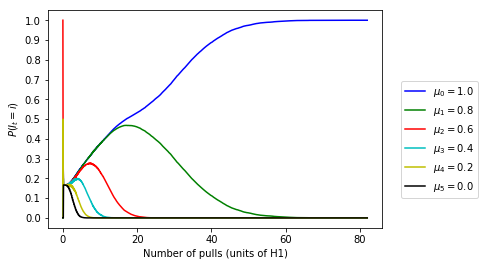

In [169]:
plot(AE)

#### UCB

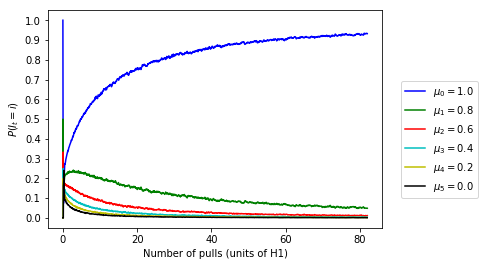

In [170]:
plot(UCB)

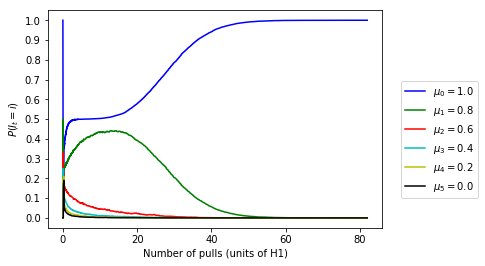

In [171]:
plot(LUCB)

### (c) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class)

In the Sutton & Barto book, they have conducted an empirical comparsion by running the algorithms over 2000 randomly generated bandits. For each bandit, the true values of arms sample from a standard normal distribution. Each arm's reward follows a normal disribution where the mean value is the predetermined true value of the arm and a unit standard deviation.<br>
To be consistent to the previous reproduced experiments, we did the following modification.<br>
1) We average the data regarding the reward and optimal action in the interval $[t-n+1,t]$ just like what the paper did in the experiment.<br>
2) We get a reward from a normal distribution with a variance of 0.25 to be consistent to the above experiment.<br>
We run the above-implemented three algorithms over 2000 trials and average the trials to get following two graphs as they did in the book:<br>

In [4]:
def main():
    """
    Main
    """
    args_delta=0.1
    args_epsilon=0.01
    args_steps=5000
    args_r_k=1
    args_trials=2000
    bandit_AE = AEBandit(arms=10, delta=args_delta, eps=args_epsilon,total_steps=args_steps,r_k=args_r_k)
    bandit_UCB = UCBBandit(arms=10, delta=args_delta, eps=args_epsilon,total_steps=args_steps)
    bandit_LUCB = LUCBBandit(arms=10, delta=args_delta, eps=args_epsilon,total_steps=args_steps)   
    for trial in range(args_trials):
        q_true = np.random.normal(0,1,10)
        bandit_AE.initialize(q_true)
        bandit_AE.learning()
        bandit_UCB.initialize(q_true)
        bandit_UCB.learning()
        bandit_LUCB.initialize(q_true)
        bandit_LUCB.learning()
    bandit_AE.average_est_dstr(args_trials)
    bandit_AE.average_reward_history(args_trials)
    bandit_AE.average_optimal_ratio(args_trials)
    bandit_UCB.average_est_dstr(args_trials)
    bandit_UCB.average_reward_history(args_trials)
    bandit_UCB.average_optimal_ratio(args_trials)
    bandit_LUCB.average_est_dstr(args_trials)
    bandit_LUCB.average_reward_history(args_trials)
    bandit_LUCB.average_optimal_ratio(args_trials)
    return bandit_AE, bandit_UCB, bandit_LUCB
AE,UCB,LUCB=main()


In [2]:
def plot2(alg,color,alg_name):
    line0, = plt.plot(range(alg.total_steps) , alg.reward_history[0:alg.total_steps], '-', color=color, markersize=2,
                      label=alg_name)
    plt.xlabel("Number of pulls (Absolute)")
    plt.ylabel("Average Reward")
    plt.yticks(np.arange(0, 1.6, 0.2))
    plt.legend(bbox_to_anchor=(0, 0.2, 1.0, 0.15))
def plot3(alg,color,alg_name):
    line0, = plt.plot(range(alg.total_steps), alg.optimal_ratio[0:alg.total_steps], '-', color=color, markersize=2,
                      label=alg_name)
    plt.xlabel("Number of pulls (Absolute)")
    plt.ylabel("Optimal Action %")
    plt.yticks(np.arange(0, 1.0, 0.1))
    plt.legend(bbox_to_anchor=(0, 0.2, 1.0, 0.15))


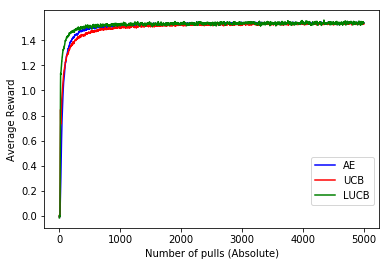

In [5]:
plot2(AE,'b',"AE")
plot2(UCB,'r',"UCB")
plot2(LUCB,'g',"LUCB")
plt.show()

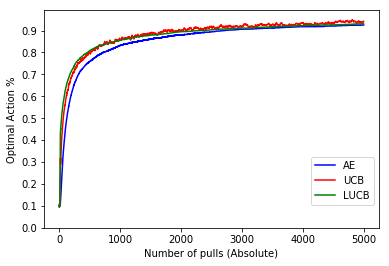

In [7]:
plot3(AE,'b',"AE")
plot3(UCB,'r',"UCB")
plot3(LUCB,'g',"LUCB")
plt.show()

The above two figures compare the three algorithms on the 10-armed testbed. <br>
The upper graph shows the increase in expected reward with experience.
LUCB figures out the best arm extremely quickly and levels off on a high reward level while UCB and AE at beginning have a slower convergence but eventually they seems to have the same high average rewards as LUCB does.<br>
The lower graph shows that the three algorithms manage to find the best arm for around 90% of times. Still the UCB converges a bit faster than the others. 

### (d) Discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identiﬁcation. 


#### Answer
When a bandit machine owns arms of which the distributions vary from time to time--the nonstationary case. Best arm identification will be not applicable for this type of situation. Because there is no static "Best Arm" to identify. Instead, the best arm algorithm would be switching among the changing arms for the case of UCB algorithm; for the case of action elimination algorithm, it might end up with a best arm of a certain range of time steps but when the best arm changes to another eliminated arm, the algorithm will no longer be functional. On the other hand, regret optimization could still be applied to figure out the best strategy we should use to minimize total regret given a horizon. 

### (e) Appendix I
#### This part gives some potential mistakes found in the paper.

1) We think there is a typo regarding the item $U(t,\delta)=(1+\sqrt{\epsilon})\sqrt{\frac{(1+\epsilon)t \log (\frac{\log(1+\epsilon)t}{\delta})}{2t}}$ in Lemma1 of the paper. We have checked the cited paper "An optimal exploration algorithm for multi-armed bandits". It turned out the left-first $t$ on the numerator should not be there. Otherwise the algorithms would not converge.

2) We think in section 3, when talking on Action Elimination Algorithm, $C_{i,k}$ should be defined as $U(k,\delta/n)$, otherwise the following equation $2U(k,\delta/n)=2C_{a,k}=2C_{i^*,k}$ would not be holding.

3) The probability $1-\frac{2+\epsilon}{\epsilon/2}(\frac{1}{\log (1+\epsilon)})^{1+\epsilon} \delta$which has been mentioned for serveral times in the paper is a negative value if $\epsilon=0.01, \delta=0.1$ is plugged.